In [1]:
import math
import numpy as np
import scipy
import scipy.optimize as sco
from pandas_datareader import data
import pandas_datareader as web
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('darkgrid')
#plt.style.use('seaborn-muted')
import pandas as pd
import statistics
from datetime import date
import datetime as dt
from sklearn.linear_model import LinearRegression

In [2]:
# date range
start = dt.datetime(2019, 3, 20)
end = date.today()

# tickers in portfolio
tickers = ['SHOP.TO', 'CSU.TO', 'GIB-A.TO', 'OTEX.TO', 'DSG.TO', 'LSPD.TO', 'KXS.TO', 'BB.TO', 'ENGH.TO', 'CLS.TO']

# df prices
df_prices = pd.DataFrame({ticker: web.get_data_yahoo(ticker, start, end)['Adj Close']
                         for ticker in tickers})

# df daily returns
df_dr = df_prices.pct_change().dropna()

# portfolio length
port_len = len(df_dr.columns)

# text output for later
holdings = df_dr.columns
metrics = ['Predicted Return', 'Predicted Volatility', 'Predicted Sharpe Ratio']

In [3]:
# Monte Carlo
# empty arrays to store values
pred_ret = []
pred_vol = []

# Monte Carlo Simulation to generate sample portfolios
for i in range(100000):
    weights = np.random.random(port_len)
    weights /= np.sum(weights)
    pred_ret.append(np.sum(df_dr.mean() * weights) * 253)
    pred_vol.append(np.sqrt(np.dot(weights.T, np.dot(df_dr.cov() * 253, weights))))
    
# convert lists to arrays    
pred_ret = np.array(pred_ret)
pred_vol = np.array(pred_vol)

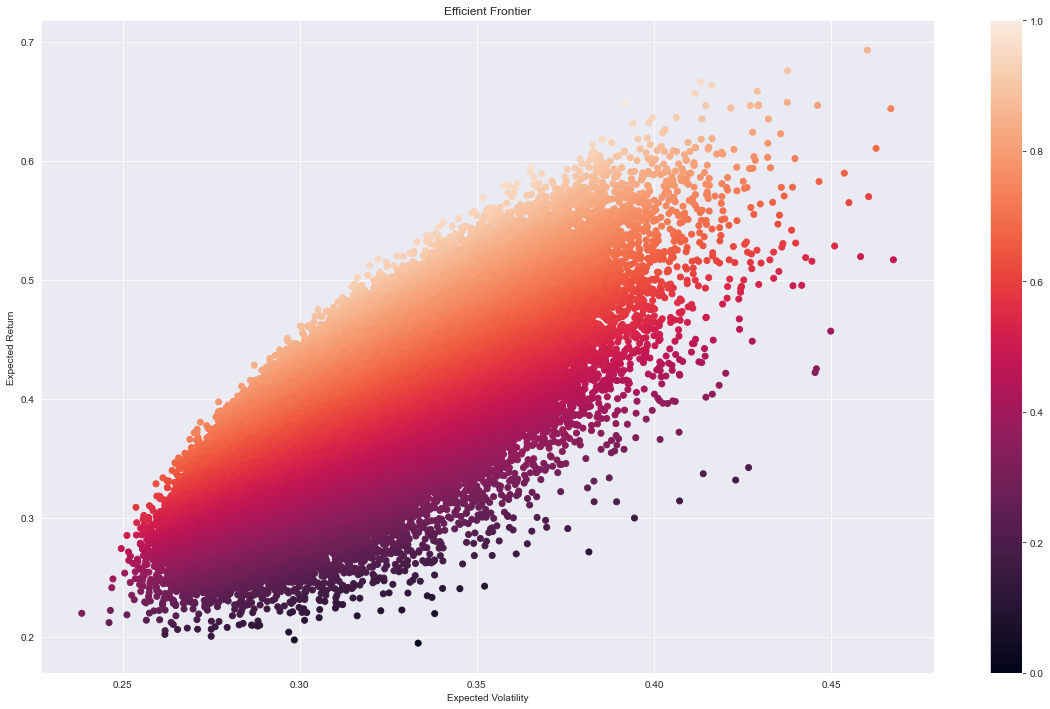

In [4]:
# visualize
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('Efficient Frontier')
ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
ax.scatter(pred_vol, pred_ret, c = pred_ret/pred_vol, marker='o')

plt.colorbar(cm.ScalarMappable(), ax=ax)
plt.show()

In [5]:
# function that takes an array of weights and then displays predicted returns, predicted volatility, and predicted sharpe ratio
def stats(weights):
    weights = np.array(weights)
    pred_returns = np.sum(df_dr.mean() * weights) * 253
    pred_volatility = np.sqrt(np.dot(weights.T, np.dot(df_dr.cov() * 253, weights)))
    
    return np.array([pred_returns,pred_volatility,pred_returns / pred_volatility])

# function that finds optimal sharpe ratio weights
def min_sharpe_func(weights):
    return -stats(weights)[2]

# function to find min variance portfolio
def min_variance_func(weights):
    return stats(weights)[1]**2

# constraints for optimization
# creating a list of constraints for the optimization 
constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
# creating a list of bounds for the optimiation
bounds = tuple((0, 1) for x in range(port_len))
# scaling our portfolio weights and creating a nice array
scaled = port_len * [1./ port_len]

# optizations
# running the optimization function for Sharpe ratio
opts_Sharpe = sco.minimize(min_sharpe_func, scaled, method='SLSQP',
                       bounds=bounds, constraints=constraints)


# optimizing using same contraints and bounds as before
opts_variance = sco.minimize(min_variance_func, scaled, method='SLSQP',
                       bounds=bounds, constraints=constraints)

In [6]:
# max sharpe portfolio composition
max_sharpe_weights = opts_Sharpe['x'].round(4).tolist()
print(dict(zip(holdings, max_sharpe_weights)))

# max sharpe portfolio analysis
max_sharpe_perf = stats(opts_Sharpe['x']).round(4).tolist()
print(dict(zip(metrics, max_sharpe_perf)))

{'SHOP.TO': 0.5895, 'CSU.TO': 0.0, 'GIB-A.TO': 0.0, 'OTEX.TO': 0.0, 'DSG.TO': 0.0, 'LSPD.TO': 0.1488, 'KXS.TO': 0.0, 'BB.TO': 0.0, 'ENGH.TO': 0.2617, 'CLS.TO': 0.0}
{'Predicted Return': 0.8198, 'Predicted Volatility': 0.462, 'Predicted Sharpe Ratio': 1.7746}


In [7]:
# min vol portfolio composition
min_var_weights = opts_variance['x'].round(4).tolist()
print(dict(zip(holdings, min_var_weights)))

# min vol predicted analysis
min_var_perf = stats(opts_variance['x']).round(4).tolist()
print(dict(zip(metrics, min_var_perf)))

{'SHOP.TO': 0.0, 'CSU.TO': 0.2802, 'GIB-A.TO': 0.4666, 'OTEX.TO': 0.108, 'DSG.TO': 0.0528, 'LSPD.TO': 0.0, 'KXS.TO': 0.0, 'BB.TO': 0.0131, 'ENGH.TO': 0.0793, 'CLS.TO': 0.0}
{'Predicted Return': 0.1888, 'Predicted Volatility': 0.2321, 'Predicted Sharpe Ratio': 0.8133}
